In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statistics
#from function import *
import statsmodels.api as sm
from datetime import datetime, timedelta
import time
from btbase import *

In [2]:
class train:
    
    # 初始化
    def __init__(self):
        self.dataframe = None
        self.data_laundry = None
        self.start_time = None
        self.end_time = None
    
    # 通过平台api获取数据
    def set_data(self, s_time, e_time, symbols='btc/usdt.spot.binance', fields=None, bar_type="1m", offset=None, engine_info=None):
        # 获取数据api
        self.dataframe = get_crypto_price(s_time, e_time, symbols=symbol_, fields=None, bar_type="1m", offset=None, engine_info=None)
        # 把收益率加入到dataframe中
        self.dataframe = self.dataframe.assign(return_close= self.dataframe['close'].pct_change() * 100)
        # 获取数据的开始时间
        self.start_time = self.dataframe['e_date'].iloc[0]
        # 获取数据的结束时间
        self.end_time = self.dataframe['e_date'].iloc[-1]
    
    # 通过dataframe文件获取数据
    def set_data_df(self, dataframe):
        # 本地dataframe
        self.dataframe = dataframe  
        # 把收益率加入到dataframe中 
        self.dataframe = self.dataframe.assign(return_close= self.dataframe['close'].pct_change() * 100) 
        # 获取数据的开始时间
        self.start_time = self.dataframe['e_date'].iloc[0] 
        # 获取数据的结束时间
        self.end_time = self.dataframe['e_date'].iloc[-1]
        
    
    # 方程用来得到相应步长的volatility
    # 结果是顺序的dataframe包含每个以小时为单位的区间volatility
    def get_volatility(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        volatility = []
        # 在dataframe中取出相应区间的收益率并计算标准差得到volatility
        for i in hour_table.index:
            volatility.append(np.std(self.dataframe['return_close'][(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])].dropna()))
        # 加入dataframe
        hour_table['volatility'] = volatility
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)
    
    # 相应步长内最高和最低值的差值
    # 结果是顺序的dataframe包含每个以小时为单位的区间high和low的差值
    def get_maximum_highlow_difference(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        # 这样就可以得到每个区间的starttime 区间长度为time_step
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))

        difference = []
        # 在dataframe中取出相应区间的最高和最低值做差
        for i in hour_table.index:
            # 根据hour_table的starttime和endtime取出相应的dataframe
            df_curr = self.dataframe[(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])]
            # 取出最高和最低值
            high = max(df_curr['high'].dropna())
            low = min(df_curr['low'].dropna())
            difference.append(high - low)
        # 加入dataframe
        hour_table['highlow_difference'] = difference
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)      
    
    
    # 相应步长内每分钟high和low的差值的标准差
    # 结果是顺序的dataframe包含每个以小时为单位的区间high和low的差值的标准差
    def get_highlow(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        # 这样就可以得到每个区间的starttime 区间长度为time_step
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))

        highlow = []
        # 在dataframe中取出相应区间的high和low的差值并计算标准差得到
        for i in hour_table.index:
            # 根据hour_table的starttime和endtime取出相应的dataframe
            df_curr = self.dataframe[(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])]
            highlow.append(np.sum(df_curr['high'] - df_curr['low']))

        # 加入dataframe
        hour_table['highlow'] = highlow
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)  
    
    # 计算每个区间volume_sum
    # 结果是顺序的dataframe包含每个以小时为单位的区间volume_sum
    def get_volume_sum(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        # 这样就可以得到每个区间的starttime 区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))

        volume_sum = []
        # 在dataframe中取出相应区间的high和low的差值并计算标准差得到
        for i in hour_table.index:
            # 根据hour_table的starttime和endtime取出相应的dataframe
            df_curr = self.dataframe[(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])]
            volume_sum.append(np.sum(df_curr['volume']))
        
        # 加入dataframe
        hour_table['volume_sum'] = volume_sum
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)  

    # 计算每个区间头尾的收益率的平方(Rt^2)
    # Rt = (Pt - Pt-1)/Pt-1
    # 这里t以timestep为单位
    def get_return_square(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        
        return_square = []
        # 在dataframe中取出相应区间的high和low的差值并计算标准差得到
        for i in hour_table.index:
            # 根据hour_table的starttime和endtime取出相应的dataframe
            close = self.dataframe['close'][(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])].dropna()
            # Rt^2 = ((Pt - Pt-1)/Pt-1)^2
            return_square.append(((close.values[0] - close.values[-1] )/ close.values[0])**2)
            #return_square.append((np.log(close.values[0]/close.values[-1]))**2)

        # 加入dataframe
        hour_table['return_square'] = return_square
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)
    
    # 计算每个区间volume_sum的zscore
    # zscore = (x - mean(x))/std(x)
    # 这里mean(x)是每个period内的volume_sum的均值 period用小时作为单位
    # std(x)是每个period内的volume_sum的标准差
    # x是每个time_step内的volume_sum
    def get_zscore(self, time_step, period):
        # 得到每个time_step的volume_sum
        original = self.get_volume_sum(time_step)
        zscore = []
        
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据period确定每个mean和std范围
        hour_table.insert(0, 'hour_s_period' , time_range + timedelta(hours = - period))  
        
        # 删除最后一个区间
        # 因为最后一个区间的数据是不完整的
        hour_table = hour_table.iloc[:-period]
        
        # 计算zscore
        for i in hour_table.index:
            # 取出相应区间的volume_sum
            df_curr = original[(original.hour_e_time > hour_table.hour_s_period[i]) & (original.hour_e_time <=  hour_table.hour_e_time[i])]
            zscore.append((df_curr['volume_sum'].iloc[-1] - np.mean(df_curr['volume_sum']))/np.std(df_curr['volume_sum']))
        
        # 加入dataframe
        hour_table['zscore'] = zscore
        
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)   

    # 得到模型
    # order: 每个变量的阶数
    # order[0]: highlow_difference
    # order[1]: highlow
    # order[2]: volume_sum
    # order[3]: return_square
    # order[4]: volatility
    # order[5]: zscore
    # timestep: 每个变量的时间步长 这里timestep[5]是一个list 第一个是zscore的时间步长 第二个是zscore的period
    # ma: moving average的阶数
    # 模型是volatility = a0 + b(n)*highlow_difference(t-n) + c(n)*highlow(t-n) + d(n)*volume_sum(t-n) + e(n)*return_square(t-n) + f(n)*volatility(t-n) + g(n)*zscore(t-n) + h(n)*error(t-n) + error
    def HLVGARCH_MA(self, order = [1, 1, 1, 1, 1, 1], timestep = [60, 60, 60, 60, 60, [60, 24]], ma = 0):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        self.data_laundry = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        self.data_laundry.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - 60))
        # 换成顺序排列
        self.data_laundry = self.data_laundry.dropna()[::-1].reset_index(drop=True)
        
        # 得到volatility
        dataframe_volatility_real = self.get_volatility(60).drop(columns = ['hour_s_time'])
        
        # 把真实的volatility加入到dataframe中
        self.data_laundry = self.data_laundry.merge(dataframe_volatility_real, on = 'hour_e_time', how = 'inner')

        if order[0] >0:
            # 得到每个时段的highlow_difference
            dataframe_highlow_diff = self.get_maximum_highlow_difference(timestep[0]).drop(columns = ['hour_s_time'])
            for i in range(order[0]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的highlow_difference
                dataframe_highlow_diff['highlow_difference_t' + str(i)] = dataframe_highlow_diff['highlow_difference'].shift(i+1)  
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_highlow_diff.drop(columns = ['highlow_difference']), on = 'hour_e_time', how = 'inner')
        
        if order[1] >0:
            # 得到每个时段的highlow sum
            dataframe_highlow = self.get_highlow(timestep[1]).drop(columns = ['hour_s_time'])
            for i in range(order[1]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的highlow
                dataframe_highlow['highlow_t' + str(i)] = dataframe_highlow['highlow'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_highlow.drop(columns = ['highlow']), on = 'hour_e_time', how = 'inner')

        if order[2] >0:
            # 得到每个时段的volume_sum
            dataframe_volume_sum = self.get_volume_sum(timestep[2]).drop(columns = ['hour_s_time'])
            for i in range(order[2]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volume_sum
                dataframe_volume_sum['volume_sum_t' + str(i)] = dataframe_volume_sum['volume_sum'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_volume_sum.drop(columns = ['volume_sum']), on = 'hour_e_time', how = 'inner')

        if order[3] >0:
            # 得到每个时段的return_square
            dataframe_return_square = self.get_return_square(timestep[3]).drop(columns = ['hour_s_time'])
            for i in range(order[3]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的return_square
                dataframe_return_square['return_square_t' + str(i)] = dataframe_return_square['return_square'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_return_square.drop(columns = ['return_square']), on = 'hour_e_time', how = 'inner')

        if order[4] >0:
            # 得到每个时段的volatility
            dataframe_volatility = self.get_volatility(timestep[4]).drop(columns = ['hour_s_time'])
            for i in range(order[4]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volatility
                dataframe_volatility['volatility_t' + str(i)] = dataframe_volatility['volatility'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_volatility.drop(columns = ['volatility']), on = 'hour_e_time', how = 'inner')

        if order[5] >0:
            # 得到每个时段的zscore
            dataframe_zscore = self.get_zscore(timestep[5][0], timestep[5][1]).drop(columns = ['hour_s_period'])
            for i in range(order[5]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的zscore
                dataframe_zscore['zscore_t' + str(i)] = dataframe_zscore['zscore'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_zscore.drop(columns = ['zscore']), on = 'hour_e_time', how = 'inner')    
        
        # 删除缺失值
        self.data_laundry = self.data_laundry.dropna()
       
        # 真实的volatility 用来拟合
        Y = self.data_laundry['volatility']
        # 除了volatility的其他数据 用来作为自变量
        X = self.data_laundry.drop(columns = ['hour_e_time', 'hour_s_time', 'volatility'])
        
        # 拟合模型
        model = sm.OLS(Y, sm.add_constant(X)).fit()
        
        # 预测volatility
        self.data_laundry['predict_volatility'] = model.predict(sm.add_constant(X))
    
        self.data_laundry['volatility'] = self.data_laundry['volatility']
        
        # 如果有moving average
        if ma > 0:
            # 计算误差
            self.data_laundry['error'] = self.data_laundry['volatility'] - self.data_laundry['predict_volatility']
            # 得到t-1, t-2, t-3。。。的误差
            for i in range(ma):
                self.data_laundry['error_t' + str(i)] = self.data_laundry['error'].shift(i+1)
            
            # 删除缺失值
            self.data_laundry = self.data_laundry.dropna()
            # 真实的volatility 用来拟合
            Y = self.data_laundry['volatility']
            # 除了volatility的其他数据 用来作为自变量
            X = self.data_laundry.drop(columns = ['hour_e_time', 'hour_s_time', 'volatility', 'predict_volatility', 'error'])
            # 拟合模型
            model = sm.OLS(Y, sm.add_constant(X)).fit()  
            self.data_laundry = self.data_laundry.drop(columns = ['error']) 

        
        # 加入真实volatility和预测volatility
        self.data_laundry['real'] = self.data_laundry['volatility']
        self.data_laundry['predict'] = model.predict(sm.add_constant(X))
        
        # 删除不需要的数据
        self.data_laundry = self.data_laundry.drop(columns = ['volatility', 'predict_volatility'])
        return model

In [3]:
symbol_ = 'btc/usdt.spot.binance'
# set the start time
s_time = datetime.datetime(2023, 1 ,1, 2, 0, 0)
# set the end time
e_time = datetime.datetime(2024, 1, 1, 1, 59, 0)

In [4]:
data = train()
data.set_data(s_time, e_time, symbols='btc/usdt.spot.binance', fields=None, bar_type="1m", offset=None, engine_info=None)

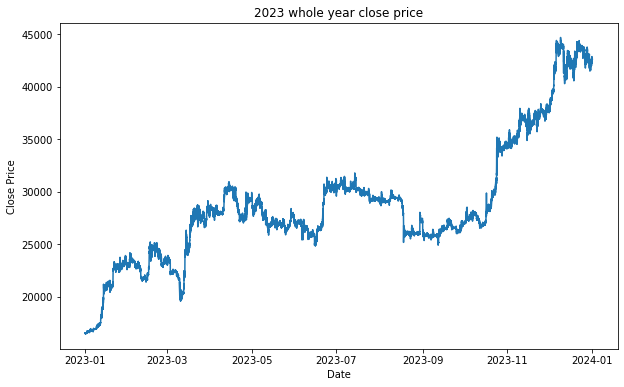

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(data.dataframe['e_date'], data.dataframe['close'])
plt.title('2023 whole year close price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

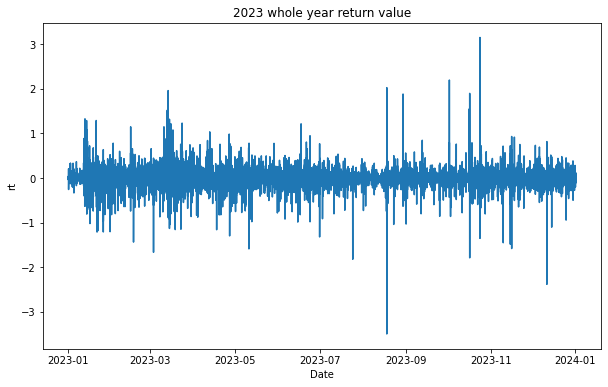

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(data.dataframe['e_date'], data.dataframe['return_close'])
plt.title('2023 whole year return value')
plt.xlabel('Date')
plt.ylabel('rt')
plt.show()

In [7]:
model = data.HLVGARCH_MA(order =  [0, 1, 1, 0, 1, 0], timestep = [30, 60, 10, 90, 10, [30, 5]], ma = 0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             volatility   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     1987.
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:55:51   Log-Likelihood:                 19039.
No. Observations:                8759   AIC:                        -3.807e+04
Df Residuals:                    8755   BIC:                        -3.804e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.000     40.852      0.000       0.018       0.020
highlow_t0     1.772e-05    5.1e-07     34.737      0.000    1.67e-05    1.87e-05
volume_sum_t0  4.089e-06   3.28e-07     12.463      0.000    3.45e-06    4.73e-06
volatility_t0     0.1889      0.014     13.875      0.000       0.162       0.216
==============================================================================
Omnibus:                    10934.991   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3610147.354
Skew:                           6.507   Prob(JB):                         0.00
Kurtosis:                     101.603   Cond. No.                     7.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
data.data_laundry

,hour_s_time,hour_e_time,highlow_t0,volume_sum_t0,volatility_t0,real,predict
1,2023-01-01 03:00:00,2023-01-01 04:00:00,169.31,616.40091,0.013108,0.014589,0.027195
2,2023-01-01 04:00:00,2023-01-01 05:00:00,233.46,687.59199,0.012919,0.008071,0.028587
3,2023-01-01 05:00:00,2023-01-01 06:00:00,156.82,444.98052,0.008206,0.011327,0.025347
4,2023-01-01 06:00:00,2023-01-01 07:00:00,210.62,741.65360,0.013652,0.057779,0.028542
5,2023-01-01 07:00:00,2023-01-01 08:00:00,556.56,1873.99449,0.109621,0.028060,0.057434
...,...,...,...,...,...,...,...
8755,2023-12-31 21:00:00,2023-12-31 22:00:00,1324.29,328.09425,0.070863,0.041415,0.057394
8756,2023-12-31 22:00:00,2023-12-31 23:00:00,1080.91,98.92920,0.031604,0.039279,0.044727
8757,2023-12-31 23:00:00,2024-01-01 00:00:00,879.98,126.30466,0.030701,0.051141,0.041108
8758,2024-01-01 00:00:00,2024-01-01 01:00:00,1154.24,90.58316,0.049189,0.042526,0.049314


In [9]:
data.data_laundry.corr()

,highlow_t0,volume_sum_t0,volatility_t0,real,predict
highlow_t0,1.000000,0.484984,0.719416,0.605371,0.951140
volume_sum_t0,0.484984,1.000000,0.585168,0.433347,0.680860
volatility_t0,0.719416,0.585168,1.000000,0.551874,0.867086
real,0.605371,0.433347,0.551874,1.000000,0.636469
predict,0.951140,0.680860,0.867086,0.636469,1.000000


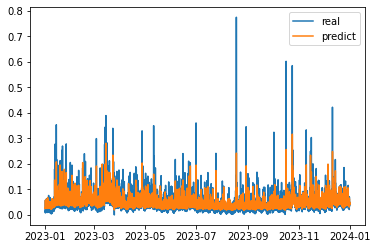

In [10]:
plt.plot(data.data_laundry['hour_e_time'], data.data_laundry['real'], label = 'real')
plt.plot(data.data_laundry['hour_e_time'], data.data_laundry['predict'], label = 'predict')
plt.legend()